In [1]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
!git clone https://github.com/Aman-Yadav-PY/Vision-Transformer-Model.git
import os
os.chdir("Vision-Transformer-Model")

Cloning into 'Vision-Transformer-Model'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 161 (delta 84), reused 80 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (161/161), 3.84 MiB | 30.22 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [3]:
import torch
import torch.nn as nn
import numpy as np


from torch.utils.data import DataLoader, Subset, random_split
from torchvision.io import decode_image
from torchvision.datasets import Food101
from torchvision.transforms import Compose, v2

from sklearn.model_selection import train_test_split
from modelpipe import HybridVitNet

from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:

root = "/kaggle/working/"
ds_path = "/kaggle/input/food101"
states_path = os.path.join(root, "checkpoint.pth")

generator = torch.Generator(device='cpu')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device: ", device)

Available Device:  cuda


In [5]:
def random_tt_split(dataset, factor):
    length= int(factor* len(dataset))
    remaining = len(dataset) - length
    datasetA, datasetB = random_split(dataset, [length, remaining], generator=generator)
    print("Splited Datset Lengths:", (len(datasetA), len(datasetB)))
    return datasetA,datasetB

In [6]:
def get_subset(dataset, test_size, s_test_size=None):
    sample_indices, _ = train_test_split(range(len(dataset)),
                                         stratify=dataset._labels,
                                         test_size=test_size, random_state=42)

    sample_ds = Subset(dataset, sample_indices)
    print("Sample size: ", len(sample_ds))
    if s_test_size:
        subset_indx = np.array(sample_ds.dataset._labels)[sample_ds.indices]
        A_len, B_len =  train_test_split(range(len(sample_ds)), stratify=subset_indx, \
                                test_size=s_test_size, random_state=42)
        A = Subset(sample_ds, A_len)
        B = Subset(sample_ds, B_len)
        print(f"Subset samples size: {len(A)}, {len(B)}")

    print("Data Subset has been prepared.")
    return (A, B) if s_test_size else sample_ds


In [7]:
normalizer = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
interpolation = v2.InterpolationMode.BILINEAR
train_transform = v2.Compose([v2.RandomResizedCrop(224, scale=[0.7, 1], interpolation=interpolation),v2.ToDtype(torch.float32, scale=True), normalizer])
test_transform = v2.Compose([v2.Resize(256), v2.CenterCrop(224), v2.ToDtype(torch.float32), normalizer])
#agmentation?

trainset = Food101(ds_path,split='train',download=True, transform=train_transform, loader=decode_image)
testset = Food101(ds_path, split='test', download=True, transform=test_transform, loader=decode_image)

In [8]:
img, label = trainset[5051]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.4134207].


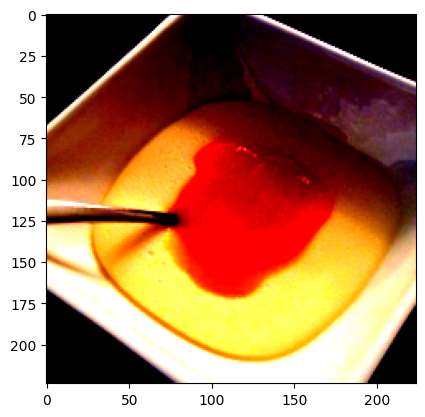

In [9]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [10]:
print("Test & Validation sets")
testset, validset = get_subset(testset, 101, 0.15)
print("\nSmall sample sets")
s_trainset, s_testset = get_subset(trainset, 0.75, 0.2)

Test & Validation sets
Sample size:  25149
Subset samples size: 21376, 3773
Data Subset has been prepared.

Small sample sets
Sample size:  18937
Subset samples size: 15149, 3788
Data Subset has been prepared.


In [11]:
torch.cuda.get_device_name()

'Tesla T4'

In [12]:
%%writefile utility.py
import torch

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0

        else:
            self.counter += 1 
            if self.counter >= self.patience:
                return True
        return False


def save_states(epoch, model, optimizer, scheduler, loss, path):
    state_dict_values = {
        "epoch":epoch,
        "model_state_dict":model.module.state_dict(),
        "optimizer_state_dict":optimizer.state_dict(),
        "loss":loss,
        "scheduler_state_dict":scheduler.state_dict()
    }
    torch.save(state_dict_values, path)

            

Writing utility.py


In [13]:
%%writefile trainer.py
import os
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
from utility import save_states

    
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
    

def reduce_tensor(value, device, world_size):
    if not isinstance(value, torch.Tensor):
        rt = torch.tensor(value).to(device)
    else:
        rt = value.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= world_size
    return rt

def validation_loss (model, test_data, loss_fn, device, rank, world_size):
    model.eval()

    total_loss = torch.tensor(0.0).to(device)
    sample_count = 0
    
    with torch.no_grad():
        for x, y in tqdm(test_data, disable=(rank!=0)):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss =  loss_fn(out, y)
            total_loss += loss.detach()
            sample_count += 1

    avg_loss =  total_loss/sample_count
    return reduce_tensor(avg_loss, device, world_size).item()


def model_trainer(model, trainset, testset, epoch, loss_fn, optimizer_fn, scheduler,rank, world_size, early_stopper, save_states, sampler=None, save_path=None, device=None, validator=None):
    scaler = GradScaler()
    Loss = []
    ValLoss = []
    best_loss = 1e2

    for ep in range(epoch):
        if sampler:
            sampler.set_epoch(ep)
            
        model.train()
        batch_loss = 0
        sample_count = 0

        pbar = tqdm(trainset, desc=f"Epoch {ep+1}/{epoch}", disable=(rank!=0))
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            optimizer_fn.zero_grad()

            with autocast(device_type='cuda'):
              out = model(x)
              loss = loss_fn(out, y)


            scaler.scale(loss).backward()

            scaler.unscale_(optimizer_fn) #?
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer_fn)
            scaler.update()

            sample_count+=1
            batch_loss += loss.detach()

        epoch_loss = reduce_tensor(batch_loss/sample_count,device, world_size).item()
        val_loss = validator(model, testset, loss_fn, device,rank, world_size)
        scheduler.step()

        stop_signal = torch.tensor(0).to(device)
        
        if rank==0:
            Loss.append(epoch_loss)
            ValLoss.append(val_loss)

            if early_stopper.early_stop(val_loss):
                stop_signal+=1

        dist.broadcast(stop_signal, src=0) #?

        if rank==0:

            curr_lr = optimizer_fn.param_groups[0]['lr']
            print(f"Rank 0: loss: {epoch_loss:.4f} | val_loss: {val_loss:.4f} | LR: {curr_lr:.6f}")
        
            if val_loss < best_loss:
                best_loss = val_loss
                save_states(ep, model, optimizer_fn, scheduler, best_loss, "checkpoints.pth")
                
        if stop_signal.item() > 0:
                if rank == 0:
                    print(f"Early Stopping at epoch{ep}")

                break
                
    return {"loss":Loss, "val_loss":ValLoss}


def dist_model_trainer(rank, world_size, trainset, testset, model_obj, return_dict, epoch, stop_obj, save_states_fn):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12134"
    dist.init_process_group("nccl", rank=rank, world_size = world_size)
    torch.cuda.set_device(rank)
    device = torch.device(f"cuda:{rank}")

    model = model_obj(num_classes=101, num_layers=8,logits=True).to(device)
    model.initialize_weights()
    model = DDP(model, device_ids=[rank])

    train_sampler = DistributedSampler(trainset, num_replicas=world_size, rank=rank, shuffle=True)
    train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler, num_workers=2, pin_memory=True)
    
    test_sampler = DistributedSampler(testset, num_replicas=world_size, rank=rank, shuffle=False)
    test_loader = DataLoader(testset, batch_size=64, sampler=test_sampler, num_workers=2, pin_memory=True)

    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
    early_stopper = stop_obj(patience=10)

    history = model_trainer(model, train_loader, test_loader, epoch, criterion, optimizer, \
                           scheduler, rank, world_size, early_stopper, save_states_fn, validator=validation_loss, sampler=train_sampler, device=device)

    

    if rank==0:
        return_dict['history'] = history
    dist.destroy_process_group()
            

Writing trainer.py


In [14]:
import torch.multiprocessing as mp
from trainer import dist_model_trainer
from utility import EarlyStopping, save_states

if __name__ == "__main__":
    manager = mp.Manager()
    return_dict = manager.dict()
    
    WORLD_SIZE = torch.cuda.device_count()
    EPOCH = 40
    
    mp.spawn(
        dist_model_trainer,
        args = (WORLD_SIZE, s_trainset, s_testset, HybridVitNet, return_dict, EPOCH, EarlyStopping, save_states),
        nprocs=WORLD_SIZE, 
        join=True
    )   

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 191MB/s]
100%|██████████| 82.7M/82.7M [00:00<00:00, 175MB/s]
100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


Rank 0: loss: 4.6276 | val_loss: 4.6161 | LR: 0.000300


Epoch 3/40:   0%|          | 0/119 [00:00<?, ?it/s]

Rank 0: loss: 4.6175 | val_loss: 4.6152 | LR: 0.000298


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Rank 0: loss: 4.6157 | val_loss: 4.6151 | LR: 0.000296


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Rank 0: loss: 4.6155 | val_loss: 4.6151 | LR: 0.000293


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Rank 0: loss: 4.6162 | val_loss: 4.6162 | LR: 0.000289


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Rank 0: loss: 4.6158 | val_loss: 4.6151 | LR: 0.000284


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Rank 0: loss: 4.6153 | val_loss: 4.6151 | LR: 0.000278


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Rank 0: loss: 4.6154 | val_loss: 4.6151 | LR: 0.000271


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Rank 0: loss: 4.6154 | val_loss: 4.6151 | LR: 0.000264


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Rank 0: loss: 4.6154 | val_loss: 4.6151 | LR: 0.000256


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Rank 0: loss: 4.6154 | val_loss: 4.6151 | LR: 0.000247
Early Stopping at epoch10


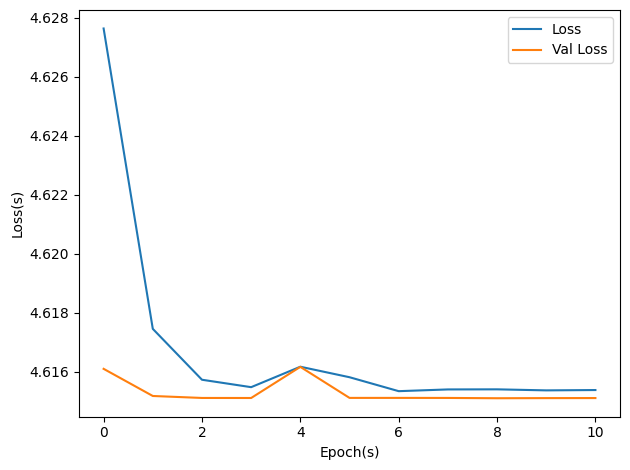

In [15]:
def loss_curve(losses):
    loss = losses['loss']
    val_loss = losses['val_loss']

    plt.plot(range(len(loss)), loss, label="Loss")
    plt.plot(range(len(val_loss)), val_loss, label="Val Loss")

    plt.xlabel("Epoch(s)")
    plt.ylabel("Loss(s)")


    plt.tight_layout()
    plt.legend()
    plt.show()

history = return_dict.get("history")
loss_curve(history)